In [1]:
!pip install qutip

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.6/31.6 MB 40.2 MB/s eta 0:00:00


In [2]:
!pip install quocs-lib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.2/68.2 kB 2.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for quocs-lib: filename=quocs_lib-0.0.66-py3-none-any.whl size=127358 sha256=3c40ef6d526aef5ae8d7e1f3dd9eb81d5cba96b6c0ab875d003ec694066cfe91
  Stored in directory: /root/.cache/pip/wheels/ed/3b/2c/23074a47ae0609fb01e0c39e97c613324117de33c3748fd663
Successfully built quocs-lib


INFO     oc_logger    The optimization direction is minimization


INFO:oc_logger:The optimization direction is minimization


QuOCS not available. Running fallback FoM test.
Error: 
Random pulses fidelity = 0.000000


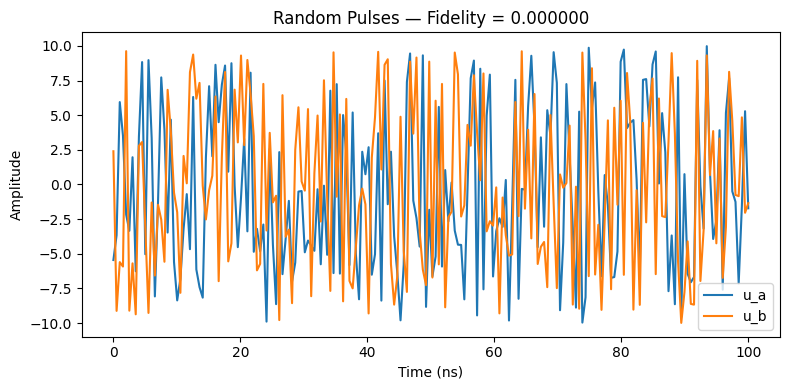

In [ ]:
import numpy as np
import qutip as qt
import matplotlib.pyplot as plt

# perbaikan

# -----------------------------------------
# System parameters
# -----------------------------------------
g_a = g_b = 26 * 2 * np.pi       # resonator–qubit coupling
g1 = g2 = 7 * 2 * np.pi          # resonator–NVE coupling
omega_a = omega_b = 2.8 * 10 * np.pi
omega_eg = 2.0 * 2 * np.pi       # qubit transition frequency

# Detunings
delta_a = omega_a - omega_eg
delta_b = omega_b - omega_eg

# Hilbert space dimensions
resonator_levels = 2
qubit_levels = 2
NVE1_levels = 3
NVE2_levels = 3

# -----------------------------------------
# Helper: tensor operator builder
# -----------------------------------------
def tensor_op(*ops):
    """Shortcut for qutip.tensor with cleaner syntax."""
    return qt.tensor(*ops)

# -----------------------------------------
# Basic annihilation/creation operators
# -----------------------------------------
a = tensor_op(qt.destroy(resonator_levels), qt.qeye(resonator_levels),
              qt.qeye(qubit_levels), qt.qeye(NVE1_levels), qt.qeye(NVE2_levels))

b = tensor_op(qt.qeye(resonator_levels), qt.destroy(resonator_levels),
              qt.qeye(qubit_levels), qt.qeye(NVE1_levels), qt.qeye(NVE2_levels))

# Qubit raising/lowering
sigma_plus = tensor_op(qt.qeye(resonator_levels), qt.qeye(resonator_levels),
                       qt.create(qubit_levels), qt.qeye(NVE1_levels), qt.qeye(NVE2_levels))
sigma_minus = sigma_plus.dag()

# -----------------------------------------
# NVE transition operators
# -----------------------------------------
def S_op(dim, i, j, nve_index):
    """Creates |i><j| operator for selected NVE."""
    ops = [qt.qeye(resonator_levels),
           qt.qeye(resonator_levels),
           qt.qeye(qubit_levels),
           qt.qeye(NVE1_levels),
           qt.qeye(NVE2_levels)]
    ops[nve_index] = qt.basis(dim, i) * qt.basis(dim, j).dag()
    return tensor_op(*ops)

# NVE1 transitions
S1_ge_plus, S1_ge_minus = S_op(3, 1, 0, 3), S_op(3, 0, 1, 3)
S1_gu_plus, S1_gu_minus = S_op(3, 2, 0, 3), S_op(3, 0, 2, 3)

# NVE2 transitions
S2_ge_plus, S2_ge_minus = S_op(3, 1, 0, 4), S_op(3, 0, 1, 4)
S2_gu_plus, S2_gu_minus = S_op(3, 2, 0, 4), S_op(3, 0, 2, 4)

# -----------------------------------------
# Static Hamiltonian (free evolution)
# -----------------------------------------
H0 = (
    delta_a * a.dag() * a
    + delta_b * b.dag() * b
    + 0.5 * omega_eg * tensor_op(qt.qeye(resonator_levels),
                                 qt.qeye(resonator_levels),
                                 qt.sigmaz(),
                                 qt.qeye(NVE1_levels),
                                 qt.qeye(NVE2_levels))
)

# Qubit-resonator control Hamiltonians
H_c_a = a * sigma_plus + a.dag() * sigma_minus
H_c_b = b * sigma_plus + b.dag() * sigma_minus

# Resonator–NVE coupling
H_resonator_nve = (
    g1 * (a * S1_ge_plus + a.dag() * S1_ge_minus)
    + g2 * (b * S2_ge_plus + b.dag() * S2_ge_minus)
)

# Add NVE coupling into bare Hamiltonian
H0 += H_resonator_nve
H_controls = [H_c_a, H_c_b]

# -----------------------------------------
# Initial and target state definitions
# -----------------------------------------
psi0 = tensor_op(qt.basis(resonator_levels, 0),
                 qt.basis(resonator_levels, 0),
                 qt.basis(qubit_levels, 0),
                 qt.basis(NVE1_levels, 0),
                 qt.basis(NVE2_levels, 0))

target_state = tensor_op(qt.basis(resonator_levels, 0),
                         qt.basis(resonator_levels, 0),
                         qt.basis(qubit_levels, 0),
                         qt.basis(NVE1_levels, 0),
                         qt.basis(NVE2_levels, 1))

# -----------------------------------------
# Piecewise evolution (for GRAPE)
# -----------------------------------------
def propagate_piecewise(H0, H_controls, pulses, psi0, total_time):
    """Evolves state under piecewise-constant Hamiltonian."""
    if len(pulses) == 0:
        raise ValueError("No pulses provided.")

    Nbins = len(pulses[0])
    for p in pulses:
        if len(p) != Nbins:
            raise ValueError("Pulse arrays must have same length.")

    dt = total_time / Nbins
    psi = psi0

    for n in range(Nbins):
        H_slice = H0 + sum(pulses[k][n] * H_controls[k] for k in range(len(H_controls)))
        U = qt.propagator(H_slice, dt)  # unitary evolution
        psi = U * psi

    return psi

# -----------------------------------------
# FoM class for QuOCS
# -----------------------------------------
try:
    from quocslib.utils.AbstractFoM import AbstractFoM
except:
    class AbstractFoM:
        pass

class HybridSystemFoM(AbstractFoM):
    """Figure-of-Merit: fidelity with respect to target state."""
    def __init__(self, H0, H_controls, psi0, target_state):
        super().__init__()
        self.H0 = H0
        self.H_controls = H_controls
        self.psi0 = psi0
        self.target_state = target_state

    def get_FoM(self, pulses, parameters, times):
        total_time = float(times[0])
        psi_final = propagate_piecewise(self.H0, self.H_controls, pulses, self.psi0, total_time)
        overlap = self.target_state.dag() * psi_final
        return {"FoM": np.abs(overlap)**2}

# -----------------------------------------
# QuOCS Optimization dictionary
# -----------------------------------------
optimization_dictionary = {
    "optimization_client_name": "HybridSystem_GRAPE_example",
    "create_logfile": False,
    "console_info": True,
    "dump_format": "npz",
    "algorithm_settings": {"algorithm_name": "GRAPE"},
    "pulses": [
        {"pulse_name": "u_a", "upper_limit": 10.0, "lower_limit": -10.0,
         "bins_number": 200, "time_name": "time_1"},
        {"pulse_name": "u_b", "upper_limit": 10.0, "lower_limit": -10.0,
         "bins_number": 200, "time_name": "time_1"}
    ],
    "parameters": [],
    "times": [{"time_name": "time_1", "initial_value": 100e-9}]
}

# -----------------------------------------
# Try running QuOCS optimizer
# -----------------------------------------
fom_obj = HybridSystemFoM(H0, H_controls, psi0, target_state)

try:
    from quocslib.Optimizer import Optimizer

    opt = Optimizer(optimization_dictionary, fom_obj)
    print("Running GRAPE optimization...")
    opt.run()
    print("Optimization complete. Check QuOCS_Results folder.")

except Exception as e:
    # Fallback: simple fidelity test using random pulses
    print("QuOCS not available. Running fallback FoM test.")
    print("Error:", e)

    bins = optimization_dictionary["pulses"][0]["bins_number"]
    total_time = optimization_dictionary["times"][0]["initial_value"]

    rng = np.random.default_rng(12345)
    u_a = rng.uniform(-10, 10, bins)
    u_b = rng.uniform(-10, 10, bins)

    pulses_test = [u_a, u_b]
    fom_value = fom_obj.get_FoM(pulses_test, None, [total_time])["FoM"]

    print(f"Random pulses fidelity = {fom_value:.6f}")

    # Plot test pulses
    tgrid = np.linspace(0, total_time, bins)
    plt.figure(figsize=(8, 4))
    plt.plot(tgrid * 1e9, u_a, label='u_a')
    plt.plot(tgrid * 1e9, u_b, label='u_b')
    plt.xlabel("Time (ns)")
    plt.ylabel("Amplitude")
    plt.title(f"Random Pulses — Fidelity = {fom_value:.6f}")
    plt.legend()
    plt.tight_layout()
    plt.show()
